<a href="https://colab.research.google.com/github/devon65/cs472-housing-pricing/blob/master/models/dl/HousingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!rm -rf cs472-housing-pricing/ data/ models/
!git clone https://github.com/devon65/cs472-housing-pricing.git
!mv cs472-housing-pricing/* .

Cloning into 'cs472-housing-pricing'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 169 (delta 70), reused 144 (delta 46), pack-reused 0
Receiving objects: 100% (169/169), 164.00 KiB | 3.42 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [0]:
!cp /content/gdrive/My\ Drive/BYU/Winter\ 2020/CS472/CS472\ Group\ Project/Data/cleaned/BLS_clean_data/MSA_master_clean.csv data/MSA_master_clean.csv
!cp /content/gdrive/My\ Drive/BYU/Winter\ 2020/CS472/CS472\ Group\ Project/Data/cleaned/Zillow/Metro_average_all.csv data/Metro_average_all.csv

# Small Auto MLP test

In [0]:
import models.machine_learning.auto_mlp

import importlib

models.machine_learning.auto_mlp = importlib.reload(models.machine_learning.auto_mlp)

In [3]:
!ls 

sample_data


In [31]:
model, acc, rmse, data = models.machine_learning.auto_mlp.train()

Adding 43-0000
Dataset loaded.
Dataset prepped.
Num training instances: 2070
Iteration 1, loss = 17116376316.85223389
Iteration 2, loss = 14587280333.14978027
Iteration 3, loss = 12475327772.39335823
Iteration 4, loss = 11721873306.51262474
Iteration 5, loss = 11550948159.56902122
Iteration 6, loss = 11267710147.70444870
Iteration 7, loss = 11044675908.92876816
Iteration 8, loss = 10761762262.38409233
Iteration 9, loss = 10314757112.33071518


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 10, loss = 9897323052.29252625
Iteration 11, loss = 9292860827.00304031
Iteration 12, loss = 8619541374.49461174
Iteration 13, loss = 7841112276.44583225
Iteration 14, loss = 6966486349.87634945
Iteration 15, loss = 6068728429.03168678
Iteration 16, loss = 5253711085.34710312
Iteration 17, loss = 4698662196.20499039
Iteration 18, loss = 4556670543.53735542
Iteration 19, loss = 4515032119.54217148
Iteration 20, loss = 4506814349.42827129
Iteration 21, loss = 4531260030.93567848
Iteration 22, loss = 4430496821.47317600
Iteration 23, loss = 4422868762.97444916
Iteration 24, loss = 4450770296.78678989
Iteration 25, loss = 4438491693.34784031
Iteration 26, loss = 4425721279.88058949
Iteration 27, loss = 4473477442.15517044
Iteration 28, loss = 4606590239.73290539
Iteration 29, loss = 4462519534.67125797
Iteration 30, loss = 4441541936.31722927
Iteration 31, loss = 4423741284.06666946
Iteration 32, loss = 4415950680.76172352
Iteration 33, loss = 4417367874.32230759
Iteration 34, lo

In [33]:
acc

0.26964078250083734

In [34]:
model.score(data[0], data[2])

0.4586598575148526

In [35]:
model.score(data[1], data[3])

0.26964078250083734

# LSTM Test

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import importlib
from torch.utils.data.sampler import SubsetRandomSampler

from IPython.core.ultratb import AutoFormattedTB

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
import data.loader
data.loader = importlib.reload(data.loader)

In [0]:
class HousingDataset(Dataset):
  def __init__(self, occ_codes, columns):
    self.dataset = data.loader.HousingDataset(occ_codes)
    self.raw = [o for o in self.dataset.iterate_areas_with_window()]
    self.preloaded = [o[2].reset_index() for o in self.raw]
    self.columns = columns

  def __len__(self):
    return len(self.preloaded)

  def __getitem__(self, i):
    record = self.preloaded[i]
    feature_columns = record[self.columns]
    housing_index_column = record["HOUSING_INDEX"]
    
    seq = feature_columns.pct_change().to_numpy()[:-1]
    # import pdb; pdb.set_trace()
    tgt_prices = pd.concat([housing_index_column, housing_index_column.pct_change()], axis=1).to_numpy()
    tgt = [ tgt_prices[1][-1], tgt_prices[-2, 0], tgt_prices[-1, 0] ]

    return torch.Tensor(seq), torch.Tensor(tgt)
  

In [0]:
class HousingLSTM(nn.Module):
  def __init__(self, n_years=5, n_features=3, s_hidden=128, lstm_layers=2):
    super(HousingLSTM, self).__init__()
    self.norm = nn.BatchNorm1d(n_years - 1)
    self.lstm = nn.LSTM(n_features, s_hidden, num_layers=lstm_layers, batch_first=True)
    self.final = nn.Sequential(
          nn.ReLU(),
          nn.Linear(s_hidden, 1),
    )
  
  def forward(self, x):
    # import pdb; pdb.set_trace()
    h_t, c_t = None, None
    output, (h_t, c_t) = self.lstm(self.norm(x))
    linear_input = output[:, -1, :].squeeze(1)
    return self.final(linear_input)

    # outputs = []
    # for i, input_t in enumerate(x):
      # lstm_o, (h_t, c_t) = self.lstm(input_t)
      # output = self.final(lstm_o)
      # outputs.append(output)
    # outputs = torch.stack(outputs, 1)
    # return outputs

In [0]:
def train(model, optimizer, dataloader, valid_loader, loss_fn, num_epochs:int, loss_selector):
  len_loader = len(dataloader)
  len_valid_loader = len(valid_loader)
  loop = tqdm(total=len_loader * num_epochs + (num_epochs // 10) * len_valid_loader, position=0)

  losses = []
  rmses = []

  valid_losses = []
  valid_rmses = []

  for e in range(num_epochs):
    build_losses = []
    build_rmses = []

    for i, (seq, target) in enumerate(dataloader):
      seq, target, last_year, this_year = seq.cuda(async=False), target[:,0].cuda(async=False).view(-1), target[:,1].cuda(async=False).view(-1), target[:,2].cuda(async=False).view(-1)
      # print(last_year, this_year)
      seq[seq != seq] = 0
      target[target != target] = 0
      last_year[last_year != last_year] = 0
      this_year[this_year != this_year] = last_year[this_year != this_year]

      optimizer.zero_grad()

      
      preds = model(seq).view(-1)
      # print(preds)
      loss = loss_fn(preds, target)
      reg_loss = loss_fn(preds, torch.zeros(target.shape).cuda())
      

      # import pdb; pdb.set_trace()

      build_losses.append(loss.item())
      rmse = torch.sqrt(loss_fn(last_year * (1 + preds), this_year))
      build_rmses.append(rmse.item())

      rmse.backward()
      optimizer.step()

      loop.update(1)
      loop.set_description(f"Epoch {e}, it: {i}/{len_loader}; Loss: {loss.item()}; RMSE: {rmse.item()}")

    losses.append(build_losses)
    rmses.append(build_rmses)

    if e % 10 == 0:
      with torch.no_grad():
        build_losses = []
        build_rmses = []
        for i, (seq, target) in enumerate(valid_loader):
          seq, target, last_year, this_year = seq.cuda(async=False), target[:,0].cuda(async=False).view(-1), target[:,1].cuda(async=False).view(-1), target[:,2].cuda(async=False).view(-1)
          # print(last_year, this_year)
          seq[seq != seq] = 0
          target[target != target] = 0
          last_year[last_year != last_year] = 0
          this_year[this_year != this_year] = last_year[this_year != this_year]
          
          preds = model(seq).view(-1)

          loss = loss_fn(preds, target)
          
          build_losses.append(loss.item())
          rmse = torch.sqrt(loss_fn(last_year * (1 + preds), this_year))
          build_rmses.append(rmse.item())

          loop.set_description(f"[VALIDATING] Epoch {e}, it: {i}/{len_valid_loader}; Loss: {loss.item()}; RMSE: {rmse.item()}")
        valid_losses.append(build_losses)
        valid_rmses.append(build_rmses)

  return losses, rmses, valid_losses, valid_rmses

In [0]:
model = HousingLSTM()


In [38]:
dataset = HousingDataset(["00-0000"], [ "HOUSING_INDEX", "TOT_EMP", "H_MEDIAN" ]) 
# split to train val
validation_split = 0.1
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if True:
    # np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(
    dataset,
    batch_size=32,
    sampler=train_sampler)

valid_loader = DataLoader(
    dataset,
    batch_size=32,
    sampler=valid_sampler)

Adding 00-0000


In [0]:
optimizer = optim.Adam(model.cuda().parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

In [40]:
losses, rmses, valid_losses, valid_rmses = train(model, optimizer, train_loader, valid_loader,  loss_fn, 21)

[VALIDATING] Epoch 20, it: 7/8; Loss: 0.0056273299269378185; RMSE: 4196.6357421875:  99%|█████████▉| 1449/1465 [04:27<00:02,  5.77it/s]

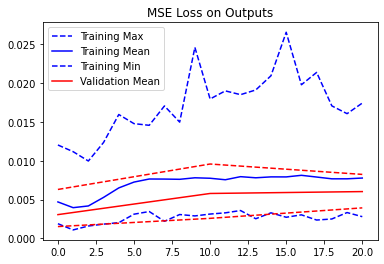

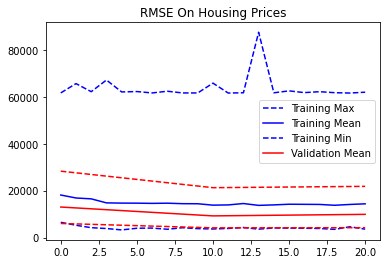

In [64]:
max_losses = list(map(lambda x: np.max(x).item(), losses))
mean_losses = list(map(lambda x: np.mean(x).item(), losses))
min_losses = list(map(lambda x: np.min(x).item(), losses))

max_valid_losses = list(map(lambda x: np.max(x).item(), valid_losses))
mean_valid_losses = list(map(lambda x: np.mean(x).item(), valid_losses))
min_valid_losses = list(map(lambda x: np.min(x).item(), valid_losses))

plt.title("MSE Loss on Outputs")
plt.plot(max_losses, "b--", label="Training Max")
plt.plot(mean_losses, "b-", label="Training Mean")
plt.plot(min_losses, "b--", label="Training Min")
plt.plot(range(0, 30, 10), max_valid_losses, "r--")
plt.plot(range(0, 30, 10), mean_valid_losses, "r-", label="Validation Mean")
plt.plot(range(0, 30, 10), min_valid_losses, "r--")
plt.legend(loc="best")
plt.show()

max_rmses = list(map(lambda x: np.max(x).item(), rmses))
mean_rmses = list(map(lambda x: np.mean(x).item(), rmses))
min_rmses = list(map(lambda x: np.min(x).item(), rmses))

max_valid_rmses = list(map(lambda x: np.max(x).item(), valid_rmses))
mean_valid_rmses = list(map(lambda x: np.mean(x).item(), valid_rmses))
min_valid_rmses = list(map(lambda x: np.min(x).item(), valid_rmses))

plt.title("RMSE On Housing Prices")
plt.plot(max_rmses, "b--", label="Training Max")
plt.plot(mean_rmses, "b-", label="Training Mean")
plt.plot(min_rmses, "b--", label="Training Min")
plt.plot(range(0, 30, 10), max_valid_rmses, "r--")
plt.plot(range(0, 30, 10), mean_valid_rmses, "r-", label="Validation Mean")
plt.plot(range(0, 30, 10), min_valid_rmses, "r--")
plt.legend(loc="best")
plt.show()

In [65]:
ending = rmses[-1]
print("Test")
print(f"Max RMSE: {np.max(ending)}")
print(f"Median RMSE: {np.median(ending)}")
print(f"Mean RMSE: {np.mean(ending)}")
print(f"Min RMSE: {np.min(ending)}")

ending = valid_rmses[-1]
print("\nValidation")
print(f"Max RMSE: {np.max(ending)}")
print(f"Median RMSE: {np.median(ending)}")
print(f"Mean RMSE: {np.mean(ending)}")
print(f"Min RMSE: {np.min(ending)}")

Test
Max RMSE: 61984.83203125
Median RMSE: 7854.27197265625
Mean RMSE: 14381.718286486639
Min RMSE: 3571.893798828125

Validation
Max RMSE: 21827.451171875
Median RMSE: 8358.0927734375
Mean RMSE: 9888.964721679688
Min RMSE: 4196.6357421875


{'boxes': [<matplotlib.lines.Line2D at 0x7ff8db6e1860>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff8db6ed2b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff8db6edd30>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff8db6ed9b0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff8db6e1b70>,
  <matplotlib.lines.Line2D at 0x7ff8db6e1ef0>]}

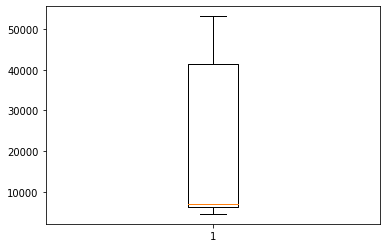

In [409]:
plt.boxplot(ending)

In [0]:
def test(i):
  inp, o = dataset[i]
  inp[inp != inp] = 0
  pred = model(inp.unsqueeze(0).cuda())
  print(pred.item())
  return ((o[1] * (1 + pred)) - o[2]).item()

In [0]:
def remove_nans(l):
  return list(filter(lambda x: not np.isnan(x), l))

In [0]:
tests = remove_nans([test(i) for i in range(len(dataset))])

In [36]:
print(tests)
print([type(t) for t in tests])
np.sqrt(np.mean(np.square(np.array(tests))))

[-2905.390625, -930.5625, -230.359375, -6537.2421875, -2624.5234375, -1440.21875, 1157.046875, -3067.625, -1038.4921875, 1705.8125, -1986.609375, 2448.0, 1509.1328125, -7277.3515625, 842.203125, 1200.7890625, 2051.515625, -1961.078125, 3425.40625, 1926.8046875, 2471.3125, 1058.375, -96.015625, -5349.375, -3579.5234375, -2304.90625, -972.3828125, -495.25, 4163.546875, -2432.109375, -9544.921875, -115.6875, -5737.84375, -7529.484375, -663.71875, -3476.15625, -7730.328125, -7101.34375, 21827.65625, 12128.1875, -4756.6875, 6036.890625, -5254.328125, -11988.15625, 6638.703125, 1514.484375, 4846.828125, -791.15625, 7529.2265625, -4812.25, -4682.5703125, -675.421875, -6567.40625, -4657.6953125, 424.1171875, 193.671875, 3379.609375, 2779.3046875, 2367.5, -805.0390625, -1035.421875, -5200.96875, 1731.7578125, -5063.890625, -2053.0625, -831.4609375, -6883.359375, 1854.9296875, -3223.421875, -8423.3671875, 3646.5859375, -3266.578125, -9250.3828125, -2450.375, 2929.515625, 3939.21875, -1384.9375, 

11346.596078679773

In [272]:
dataset[0]

(tensor([[    nan,     nan,     nan],
         [ 0.0172,  0.0490,  0.0325],
         [ 0.0634, -0.0196,  0.0191],
         [-0.1412,  0.0133,  0.0692]]),
 tensor([1.7235e-02, 9.7171e+04, 9.8336e+04]))

In [0]:
inp, o = dataset[0]
inp[inp != inp] = 0
# o = dataset[1]

In [276]:
inp

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0172,  0.0490,  0.0325],
        [ 0.0634, -0.0196,  0.0191],
        [-0.1412,  0.0133,  0.0692]])

# Save and Load Models

In [0]:
model_state = model.state_dict()
state = {
    "model": model_state,
    "occs": ["00-0000"],
    "cols": [ "HOUSING_INDEX", "TOT_EMP", "H_MEDIAN" ]
}

torch.save(state, f"/content/gdrive/My Drive/BYU/Winter 2020/CS472/CS472 Group Project/lstm_v5.mod")

In [395]:
state = torch.load(f"/content/gdrive/My Drive/BYU/Winter 2020/CS472/CS472 Group Project/lstm_v2.mod")
model.load_state_dict(state["model"])

<All keys matched successfully>

# Search Functionality

In [0]:
from sklearn.model_selection import KFold

In [0]:
available_tests = {
    "baseline": { "occ_codes": ["00-0000"], "feature_columns": ["HOUSING_INDEX", "TOT_EMP", "H_MEDIAN"], "loss_selector": lambda d, r, p: p },
    "more_features": { 
                      "occ_codes": [ "00-0000", "13-0000", "43-0000" ],
                      "feature_columns": [ "HOUSING_INDEX", "TOT_EMP", "H_MEDIAN", "H_PCT10_13-0000", "H_MEDIAN_43-0000", "TOT_EMP_43-0000" ],
                      "loss_selector": lambda d, r, p: p
                      },
    "more_years": { "occ_codes": ["00-0000"], "feature_columns": ["HOUSING_INDEX", "TOT_EMP", "H_MEDIAN"],  "n_years":7, "loss_selector": lambda d, r, p: p }
}

In [0]:
selected_tests = available_tests.keys()

In [0]:
def run_test(occ_codes, feature_columns, loss_selector, n_years:int=5, num_epochs:int=21, folds:int=6, batch_size=32):
  dataset = HousingDataset(occ_codes, feature_columns)
  indices = list(range(len(dataset)))

  loss_fn = nn.MSELoss()

  kf = KFold(n_splits=folds, shuffle=True)

  fold_rmses = []
  fold_losses = []

  fold_v_rmses = []
  fold_v_losses = []


  for i, (train_indices, valid_indices) in enumerate(kf.split(indices)):
    print(f"\nFold {i}")
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)

    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=train_sampler)

    valid_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=valid_sampler)
    
    model = HousingLSTM(5, len(feature_columns), 128, 2).cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    losses, rmses, valid_losses, valid_rmses = train(model, optimizer, train_loader, valid_loader, loss_fn, num_epochs, loss_selector)

    fold_rmses.append(rmses)
    fold_losses.append(losses)

    fold_v_rmses.append(valid_rmses)
    fold_v_losses.append(valid_losses)
  return fold_losses, fold_rmses, fold_v_losses, fold_v_rmses

In [0]:
def run_selected_tests(selected):
  res = {}
  for test in selected:
    print(f"\nRunning test {test}")
    opts = available_tests[test]
    fold_losses, fold_rmses, fold_v_losses, fold_v_rmses = run_test(**opts)
    res[test] = (fold_losses, fold_rmses, fold_v_losses, fold_v_rmses)
  return res


In [77]:
res = run_selected_tests(selected_tests)


Running test baseline
Adding 00-0000


Epoch 0, it: 0/64; Loss: 0.006452236790210009; RMSE: 18800.796875:   0%|          | 1/1370 [00:00<04:20,  5.26it/s]


Fold 0


Epoch 0, it: 0/64; Loss: 0.018257804214954376; RMSE: 38047.2578125:   0%|          | 1/1370 [00:00<04:19,  5.27it/s]


Fold 1


Epoch 0, it: 0/64; Loss: 0.008623704314231873; RMSE: 16474.38671875:   0%|          | 1/1370 [00:00<03:45,  6.07it/s]


Fold 2


Epoch 0, it: 0/64; Loss: 0.006183828227221966; RMSE: 14103.32421875:   0%|          | 1/1370 [00:00<03:40,  6.21it/s]


Fold 3


Epoch 0, it: 0/64; Loss: 0.013478823006153107; RMSE: 25542.513671875:   0%|          | 1/1370 [00:00<03:52,  5.89it/s]


Fold 4


Epoch 0, it: 0/64; Loss: 0.021174145862460136; RMSE: 19515.185546875:   0%|          | 1/1370 [00:00<04:17,  5.33it/s]


Fold 5


[VALIDATING] Epoch 20, it: 12/13; Loss: 0.008983321487903595; RMSE: 5984.62744140625:  98%|█████████▊| 1344/1370 [04:04<00:04,  5.96it/s]


Running test more_features
Adding 00-0000
Adding 13-0000
Adding 43-0000


  0%|          | 0/1370 [00:00<?, ?it/s]


Fold 0


Epoch 0, it: 0/64; Loss: 0.004258683882653713; RMSE: 13824.7373046875:   0%|          | 1/1370 [00:00<04:07,  5.54it/s]


Fold 1


Epoch 0, it: 0/64; Loss: 0.0019367430359125137; RMSE: 9718.1669921875:   0%|          | 1/1370 [00:00<03:52,  5.88it/s]


Fold 2


Epoch 0, it: 0/64; Loss: 0.004983625374734402; RMSE: 10414.0078125:   0%|          | 1/1370 [00:00<04:17,  5.31it/s]


Fold 3


Epoch 0, it: 0/64; Loss: 0.008172066882252693; RMSE: 24654.26953125:   0%|          | 1/1370 [00:00<03:53,  5.85it/s]


Fold 4


Epoch 0, it: 0/64; Loss: 0.007377377711236477; RMSE: 15508.6953125:   0%|          | 1/1370 [00:00<03:58,  5.74it/s]


Fold 5


[VALIDATING] Epoch 20, it: 12/13; Loss: 0.005034901667386293; RMSE: 8141.9599609375:  98%|█████████▊| 1344/1370 [04:12<00:04,  6.06it/s]


Running test more_years
Adding 00-0000


Epoch 0, it: 0/64; Loss: 0.012583447620272636; RMSE: 16261.017578125:   0%|          | 1/1370 [00:00<03:57,  5.76it/s]


Fold 0


Epoch 0, it: 0/64; Loss: 0.005267994478344917; RMSE: 20430.3203125:   0%|          | 1/1370 [00:00<03:44,  6.09it/s]


Fold 1


Epoch 0, it: 0/64; Loss: 0.007792592979967594; RMSE: 15718.3349609375:   0%|          | 1/1370 [00:00<03:53,  5.87it/s]


Fold 2


Epoch 0, it: 0/64; Loss: 0.016422785818576813; RMSE: 19247.359375:   0%|          | 1/1370 [00:00<03:48,  5.99it/s]


Fold 3


Epoch 0, it: 0/64; Loss: 0.010984898544847965; RMSE: 15568.7666015625:   0%|          | 1/1370 [00:00<03:56,  5.78it/s]


Fold 4


Epoch 0, it: 0/64; Loss: 0.00411206902936101; RMSE: 9172.8408203125:   0%|          | 1/1370 [00:00<04:10,  5.46it/s]


Fold 5


[VALIDATING] Epoch 20, it: 12/13; Loss: 0.005088084377348423; RMSE: 13842.19921875:  98%|█████████▊| 1344/1370 [04:08<00:04,  6.10it/s] 

baseline: Final Validation RMSE 13479.910916841947


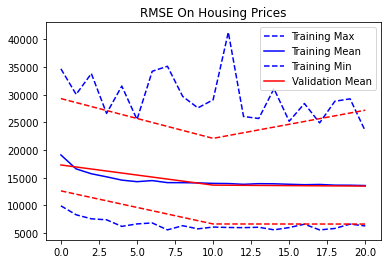

more_features: Final Validation RMSE 13777.066021259014


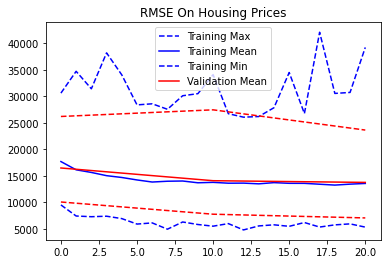

more_years: Final Validation RMSE 13435.39764560797


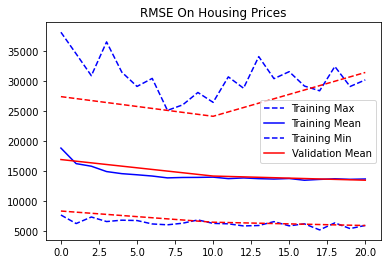

In [97]:
for key in res.keys():
  fold_losses, fold_rmses, fold_v_losses, fold_v_rmses = res[key]
  avg_v_rmses = np.array(fold_v_rmses)
  avg_rmses = np.array(fold_rmses)
  
  fold_rmse_means = avg_rmses.mean(axis=0)
  fold_v_rmse_means = avg_v_rmses.mean(axis=0)

  # print(fold_means)

  # max_losses = list(map(lambda x: np.max(x).item(), losses))
  # mean_losses = list(map(lambda x: np.mean(x).item(), losses))
  # min_losses = list(map(lambda x: np.min(x).item(), losses))

  # max_valid_losses = list(map(lambda x: np.max(x).item(), valid_losses))
  # mean_valid_losses = list(map(lambda x: np.mean(x).item(), valid_losses))
  # min_valid_losses = list(map(lambda x: np.min(x).item(), valid_losses))

  # plt.title("MSE Loss on Outputs")
  # plt.plot(max_losses, "b--", label="Training Max")
  # plt.plot(mean_losses, "b-", label="Training Mean")
  # plt.plot(min_losses, "b--", label="Training Min")
  # plt.plot(range(0, 30, 10), max_valid_losses, "r--")
  # plt.plot(range(0, 30, 10), mean_valid_losses, "r-", label="Validation Mean")
  # plt.plot(range(0, 30, 10), min_valid_losses, "r--")
  # plt.legend(loc="best")
  # plt.show()

  max_rmses = fold_rmse_means.max(axis=1)
  mean_rmses = fold_rmse_means.mean(axis=1)
  min_rmses = fold_rmse_means.min(axis=1)

  max_valid_rmses = fold_v_rmse_means.max(axis=1)
  mean_valid_rmses = fold_v_rmse_means.mean(axis=1)
  min_valid_rmses = fold_v_rmse_means.min(axis=1)

  print(f"{key}: Final Validation RMSE {mean_valid_rmses[-1]}")

  plt.title("RMSE On Housing Prices")
  plt.plot(max_rmses, "b--", label="Training Max")
  plt.plot(mean_rmses, "b-", label="Training Mean")
  plt.plot(min_rmses, "b--", label="Training Min")
  plt.plot(range(0, 30, 10), max_valid_rmses, "r--")
  plt.plot(range(0, 30, 10), mean_valid_rmses, "r-", label="Validation Mean")
  plt.plot(range(0, 30, 10), min_valid_rmses, "r--")
  plt.legend(loc="best")
  plt.show()

